#Model Development

## Import Libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder,StandardScaler
from sklearn.ensemble import RandomForestRegressor
sns.set_theme(style="whitegrid")
import warnings
import joblib
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import xgboost as xgb


## Load Data

In [ ]:
file_url = 'https://drive.google.com/uc?export=download&id=1aBxY1wImg5jLfFRzl-OGcgGPRuhk0kPd'
data = pd.read_csv(file_url, on_bad_lines='skip')
data.rename(columns={'average _delivery_time': 'average_delivery_time'}, inplace=True)
data.head()

,restaurant_name,rating,average_price,average_delivery_time,south_indian_or_not,north_indian_or_not,fast_food_or_not,street_food,biryani_or_not,bakery_or_not,location
0,# Momo,4.2,200,34,0,0,0,0,0,0,Durgapur
1,#99,4.1,100,31,0,0,0,0,0,0,Bareilly
2,#BBQ,3.6,200,57,0,0,1,0,0,0,Mangalore
3,#Dilliwaala6,3.7,100,38,0,1,0,1,0,0,Puducherry
4,#FlyFree,4.0,200,26,0,0,1,0,0,0,Ajmer


##Classification Model: Predict Customer Satisfaction (High/Low Ratings)

**Purpose:** The classification model predicts whether a restaurant is likely to receive high customer satisfaction ( ratings of 4 or higher) based on factors like price, delivery time, and the type of cuisines they offer.


**How Restaurants Can Use This:**

**Pricing Adjustments:**Restaurants can input their current average price, delivery time, and cuisine types into the model, and the model will predict whether they are likely to receive high ratings. If the prediction shows a lower probability of receiving high ratings, the restaurant can adjust prices (e.g., lowering them) or reduce delivery times to improve the chance of higher customer satisfaction.

**Menu Planning:** By testing different combinations of cuisine offerings and prices, restaurants can understand what type of cuisine mix or pricing strategy would yield the highest likelihood of receiving positive customer feedback. For example, if the model predicts higher satisfaction for a South Indian and North Indian menu at a certain price, the restaurant can focus on these cuisines.

**Operations:** If longer delivery times are leading to lower predicted satisfaction, restaurants can consider operational improvements (e.g., faster delivery services) to boost customer happiness.


**Example:**

•	Restaurant A inputs the following data:

o	Average price: ₹400

o	Delivery time: 45 minutes

o	Cuisine: South Indian, North Indian, Fast Food

•	The model predicts the  chance of receiving high customer ratings. Based on this prediction, Restaurant A can:
o	Reduce prices to ₹350 or aim to decrease delivery time to 30 minutes to increase the predicted customer satisfaction.


###Data Preparation

####Create the target variable

Create the target variable High Rating. It is binary (0 or 1), where a value of 1 indicates a rating of 4 or higher, and 0 indicates a rating below 4. This is done using the apply() function with a lambda expression to transform the original rating column into a binary outcome

In [ ]:
# Create the target variable: High Rating (1 if rating >= 4, else 0)
data['High Rating'] = data['rating'].apply(lambda x: 1 if x >= 4 else 0)

####Define features and target

The features (X) are selected from the dataset and include columns like average_price, average_delivery_time, and various categorical flags indicating cuisine types.

The target variable (y) is the High Rating column created earlier.

In [ ]:
# Define features and target
X = data[['average_price', 'average_delivery_time', 'south_indian_or_not', 'north_indian_or_not',
          'fast_food_or_not', 'street_food', 'biryani_or_not', 'bakery_or_not']]
y = data['High Rating']  # Target

###Data Splitting

To divide the data into a training set (used to train the model) and a testing set (used to evaluate the model's performance).

Here, 80% of the data is used for training, and 20% is used for testing.


The random_state=42 ensures that the split is reproducible.


In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

###Data Preprocessing

Features like average_price and average_delivery_time are continuous variables, so they need to be scaled.

Standardization (using StandardScaler) ensures that these features have a mean of 0 and a standard deviation of 1, which can help improve model performance( especially for algorithms sensitive to feature scaling)

In [ ]:
# Define preprocessing for numeric data (scaling features)
numeric_features = ['average_price', 'average _delivery_time']
numeric_transformer = StandardScaler()

###Model Definition (Pipeline)

Specify the steps involved in processing the data and applying the model .

A **pipeline** is created to chain preprocessing (scaling) and model training steps together.


The pipeline first applies **standard scaling** to numerical features and then uses the **XGBClassifier** from XGBoost for classification.


The **eval_metric='logloss'** is specified for monitoring performance during training, and **scale_pos_weight=1** helps to adjust for class imbalance in the target variable



In [ ]:
# Create a pipeline with XGBoost classifier
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),  # Scale numerical features
    ('classifier', xgb.XGBClassifier(eval_metric='logloss', scale_pos_weight=1, random_state=42))
])

###Hyperparameter Tuning

This step involves tuning the model's hyperparameters to optimize performance.

A grid of hyperparameters for the XGBClassifier is defined.

This grid includes values for the number of estimators **(n_estimators), tree depth (max_depth), learning rate (learning_rate), subsample ratio (subsample), column sampling rate (colsample_bytree), and the scale_pos_weight to handle class imbalance**.

 These hyperparameters will be tested during the grid search



In [ ]:
# Hyperparameter grid for XGBoost
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [5, 7],
    'classifier__learning_rate': [0.01, 0.05],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0],
    'classifier__scale_pos_weight': [1, 10]  # Adjust for class imbalance
}

A grid search (GridSearchCV) is performed to find the **best combination of hyperparameters.**

 The **cv=3**specifies 3-fold cross-validation for evaluating each combination of parameters.

The **scoring='roc_auc'** metric is used for evaluation, focusing on maximizing the Area Under the ROC Curve (AUC-ROC).

In [ ]:
# GridSearchCV to find the best parameters
grid_search = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1, verbose=2, scoring='roc_auc')
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric='logloss',
                                                      feature_types=None,
                                                      gamma=None,
                                                      grow_policy=None,
                                                      import...
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'classifier__colsample_bytree': [0.8, 1.0],
                         'classifier__learning_rate': [0.01, 0.05],
                         'classifier__max_depth': [5, 7],
                         'classifier__n_estimators': [100, 200],
                         'classifier__scale_pos_weight': [1, 10],
                         'classifier__subsample': [0.8, 1.0]},
             scoring='roc_auc', verbose=2)

###Model Evaluation

The best model found by GridSearchCV is used to predict the target values (y_pred) for the test data (X_test).

In [ ]:
# Evaluate the model
y_pred = grid_search.best_estimator_.predict(X_test)

###Metrics Calculation

**Accuracy:**The overall percentage of correct predictions.

**Classification Report:** Includes precision, recall, and F1-score for each class (0 and 1).

**Confusion Matrix:**Displays true positives, false positives, true negatives, and false negatives.

**ROC AUC:**The area under the Receiver Operating Characteristic curve, which provides an aggregate measure of performance across different thresholds.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

#Accuracy and other evaluation metrics
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")

# Additional Metrics
roc_auc = roc_auc_score(y_test, grid_search.best_estimator_.predict_proba(X_test)[:, 1])
print(f"ROC AUC: {roc_auc}")

Accuracy: 0.5710412147505423
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.24      0.33      2429
           1       0.58      0.83      0.69      3103

    accuracy                           0.57      5532
   macro avg       0.55      0.53      0.51      5532
weighted avg       0.56      0.57      0.53      5532

Confusion Matrix:
[[ 572 1857]
 [ 516 2587]]
ROC AUC: 0.5795699376969153


###Observations/Results




####Best Hyperparameters

Below code  outputs the best combination of hyperparameters found by the grid search, helping to understand the settings that led to the best model performance.

In [ ]:
print(f"Best Hyperparameters: {grid_search.best_params_}")


Best Hyperparameters: {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 5, 'classifier__n_estimators': 200, 'classifier__scale_pos_weight': 1, 'classifier__subsample': 0.8}


####Confusion Heat Map

Visualizes the true positive, false positive, true negative, and false negative counts

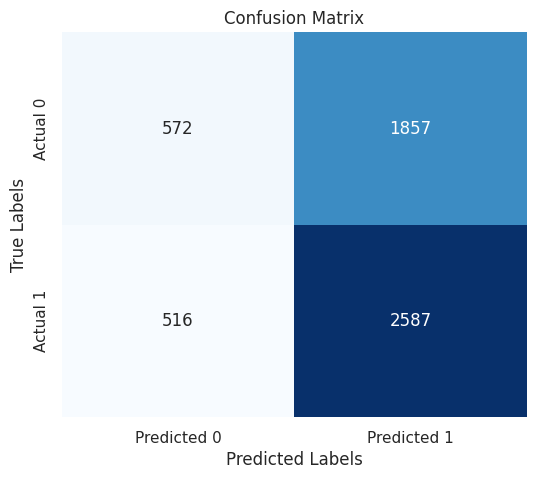

In [ ]:

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False, xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


**True Negatives (TN): 572**

These are the instances where the model correctly predicted class 0 (the negative class), which corresponds to cases where the target variable was 0, and the model's prediction was also 0.


**False Positives (FP): 1857**

These are the instances where the model incorrectly predicted class 1 (the positive class), when in reality, the target variable was 0 (negative class). This is a false positive because the model's prediction was 1 when it should have been 0.


**False Negatives (FN): 516**

These are the instances where the model incorrectly predicted class 0 (negative class), but the target variable was actually 1 (positive class). This is a false negative because the model's prediction was 0, but the actual value of the target variable was 1.


**True Positives (TP): 2587**

These are the instances where the model correctly predicted class 1 (the positive class), which corresponds to cases where the target variable was 1, and the model's prediction was also 1.

**Accuracy = 57.1%:** The model correctly predicted the target variable (whether class 0 or class 1) for 57.1% of the instances.

**Precision (Class 1) = 58.2%:** When the model predicted class 1 (positive class), it was correct 58.2% of the time


**Recall (Class 1) = 83.5%:** The model correctly identified 83.5% of all the instances where the target variable was 1.

**F1-Score (Class 1) = 68.7%:** The balance between precision and recall for class 1 is 68.7%.

**Precision (Class 0) = 52.6%:** When the model predicted class 0 (negative class), it was correct 52.6% of the time

**Recall (Class 0) = 23.5%:**The model correctly identified 23.5% of all the instances where the target variable was 0.

**F1-Score (Class 0) = 32.7%:** The balance between precision and recall for class 0 is 32.7%

**ROC AUC = 0.5796:** The model has a moderate ability to distinguish between the two classes, with an AUC value close to 0.5 (random guessing).




**The model has high recall for class 1 (positive class), but its precision for both classes is relatively low, and it struggles to predict class 0 effectively.**

####ROC Curve

Evaluates the model's ability to discriminate between classes

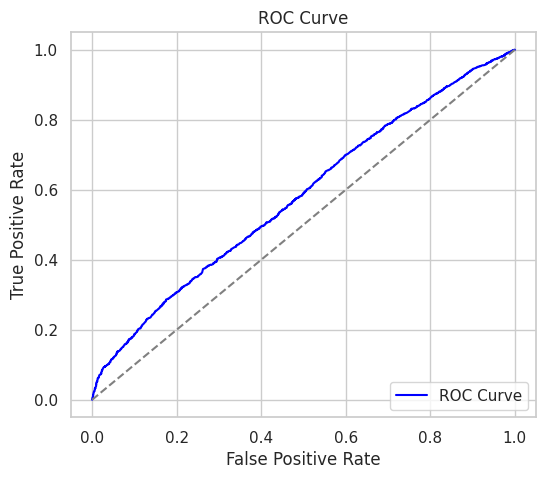

ROC AUC: 0.5795699376969153


In [ ]:
from sklearn.metrics import roc_curve

# Get the predicted probabilities for class 1
y_prob = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Plot ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', label='ROC Curve')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random classifier)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# Compute and print ROC AUC score
print(f"ROC AUC: {roc_auc_score(y_test, y_prob)}")


####Precision Recall Curve

Shows the trade-off between precision and recall at different thresholds

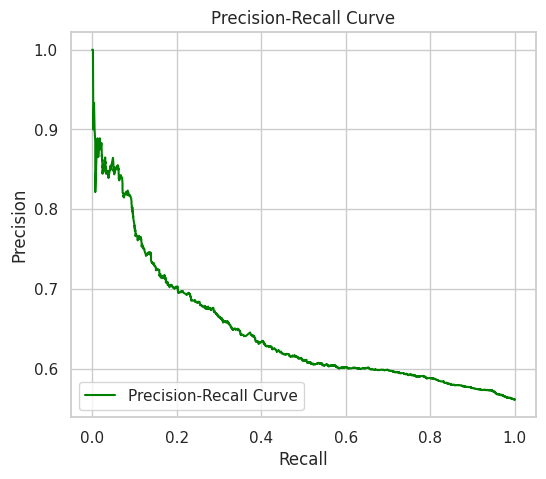

In [ ]:
from sklearn.metrics import precision_recall_curve

# Get the precision-recall curve data
precision, recall, _ = precision_recall_curve(y_test, y_prob)

# Plot Precision-Recall curve
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, color='green', label='Precision-Recall Curve')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.show()


####Feature Importance Plot (for XGBoost)

Identifies which features contribute most to model predictions.

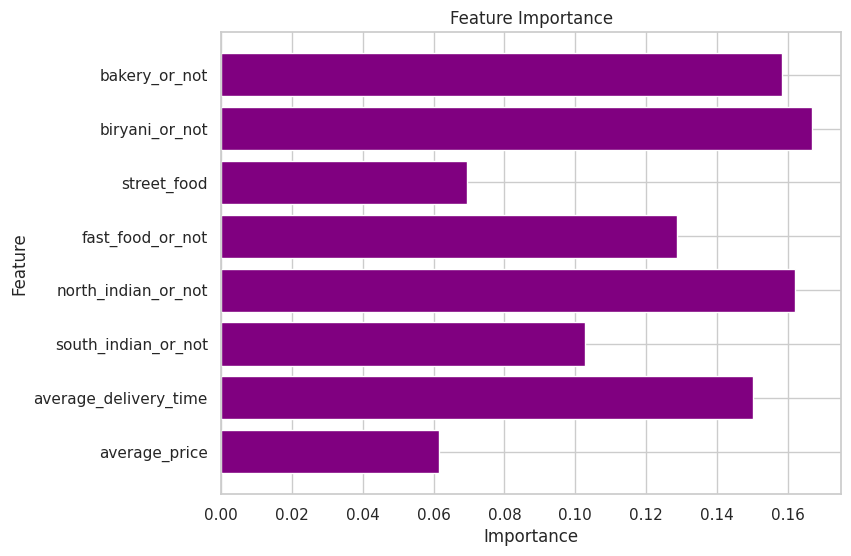

In [ ]:
# Get feature importance from XGBoost
xgb_model = grid_search.best_estimator_.named_steps['classifier']
feature_importances = xgb_model.feature_importances_

# Create a bar plot for feature importances
features = X.columns
plt.figure(figsize=(8, 6))
plt.barh(features, feature_importances, color='purple')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


####Learning Curve

Illustrates model performance during training to diagnose overfitting or underfitting.

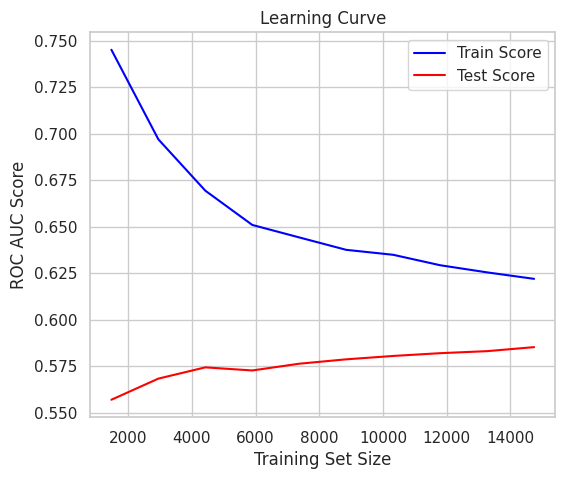

In [ ]:
from sklearn.model_selection import learning_curve

# Get learning curve data
train_sizes, train_scores, test_scores = learning_curve(
    grid_search.best_estimator_, X_train, y_train, cv=3, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='roc_auc'
)

# Plot learning curve
plt.figure(figsize=(6, 5))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Train Score', color='blue')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Test Score', color='red')
plt.title('Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('ROC AUC Score')
plt.legend(loc='best')
plt.show()


####Model Calibration

Checks how well the predicted probabilities match the true probabilities

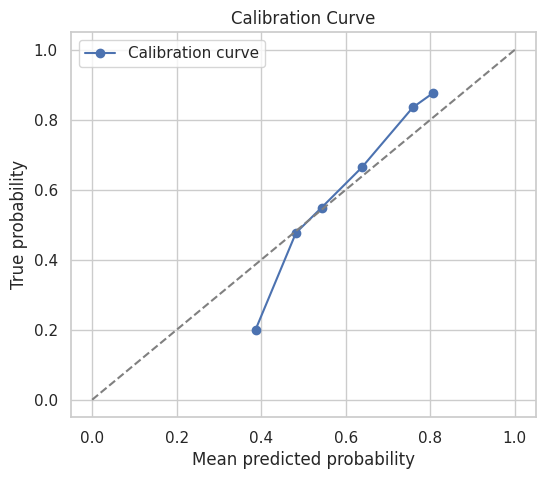

In [ ]:
from sklearn.calibration import calibration_curve

# Get predicted probabilities
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)

# Plot calibration curve
plt.figure(figsize=(6, 5))
plt.plot(prob_pred, prob_true, marker='o', label='Calibration curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('Calibration Curve')
plt.xlabel('Mean predicted probability')
plt.ylabel('True probability')
plt.legend(loc='best')
plt.show()


##Regression Model: Optimal Price Prediction

**Purpose:** The regression model recommends the optimal price range a restaurant should charge to maximize customer satisfaction based on delivery time, cuisine offerings, and historical pricing trends.


**How Restaurants Can Use This:**

•	Price Setting: Restaurants can input their current delivery time and cuisine types into the model, and it will output a price range that is most likely to result in high customer satisfaction. The restaurant can then set their menu prices within that recommended range to attract more customers and maintain profitability.

•	Dynamic Pricing: Restaurants can use the model to dynamically adjust prices based on real-time operational data. For example, if delivery times are increasing due to peak hours or traffic, the restaurant can lower its prices slightly to maintain customer satisfaction and avoid negative reviews.

•	Menu Optimization: Restaurants can experiment with different cuisine combinations to see how they affect the optimal price. For instance, adding Biryani to a menu that previously only had North Indian food may allow the restaurant to increase prices slightly without negatively affecting customer satisfaction.

Example:

•	Restaurant B inputs the following data:

o	Delivery time: 40 minutes

o	Cuisines: North Indian, Bakery

•	The model predicts that the optimal price range is ₹300-₹350 for these parameters. If the restaurant is currently charging ₹400, it may consider lowering the price to within the optimal range to boost customer satisfaction, attract more customers, and improve ratings.


###Data Preparation

In [2]:
file_url = 'https://drive.google.com/uc?export=download&id=1aBxY1wImg5jLfFRzl-OGcgGPRuhk0kPd'
data = pd.read_csv(file_url, on_bad_lines='skip')
data.rename(columns={'average _delivery_time': 'average_delivery_time'}, inplace=True)
data.head()

,restaurant_name,rating,average_price,average_delivery_time,south_indian_or_not,north_indian_or_not,fast_food_or_not,street_food,biryani_or_not,bakery_or_not,location
0,# Momo,4.2,200,34,0,0,0,0,0,0,Durgapur
1,#99,4.1,100,31,0,0,0,0,0,0,Bareilly
2,#BBQ,3.6,200,57,0,0,1,0,0,0,Mangalore
3,#Dilliwaala6,3.7,100,38,0,1,0,1,0,0,Puducherry
4,#FlyFree,4.0,200,26,0,0,1,0,0,0,Ajmer


####Prepare features and Target

In [3]:
X = data.drop(columns=['restaurant_name', 'average_price'])
y = data['average_price']

####Data Preprocessing

In [4]:
categorical_features = ['location']
numeric_features = ['rating', 'average_delivery_time', 'south_indian_or_not',
                    'north_indian_or_not', 'fast_food_or_not', 'street_food',
                    'biryani_or_not', 'bakery_or_not']


In [5]:
# Create column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numeric_features)
    ]
)

###Train and Test data split


To divide the data into a training set (used to train the model) and a testing set (used to evaluate the model's performance).

Here, 70% of the data is used for training, and 30% is used for testing.

The random_state=42 ensures that the split is reproducible

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.head()


,rating,average_delivery_time,south_indian_or_not,north_indian_or_not,fast_food_or_not,street_food,biryani_or_not,bakery_or_not,location
19960,3.6,37,0,1,0,0,0,0,Surat
9767,4.0,49,0,1,0,0,0,0,Kanpur
21289,4.3,34,0,1,0,0,1,0,Pune
27228,3.4,28,0,0,1,1,0,1,Dehradun
8187,3.8,37,0,0,0,0,0,0,Indore


###Model Definition

Here define a dictionary of regression models and their associated hyperparameters for grid search tuning. Each model (e.g., Random Forest, Gradient Boosting, XGBoost, SVR) is paired with its specific hyperparameter options, such as the number of estimators, learning rate, and kernel type. These settings will be passed to GridSearchCV to find the best combination of hyperparameters for each model. This approach ensures systematic and optimized model training.

In [7]:
models = {
    'Random Forest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'regressor__n_estimators': [50, 100, 200],
            'regressor__max_depth': [None, 10, 20],
            'regressor__min_samples_split': [2, 5, 10]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingRegressor(random_state=42),
        'params': {
            'regressor__n_estimators': [50, 100, 200],
            'regressor__learning_rate': [0.01, 0.1, 0.2],
            'regressor__max_depth': [3, 5, 10]
        }
    },
    'XGBoost': {
        'model': xgb.XGBRegressor(random_state=42),
        'params': {
            'regressor__n_estimators': [50, 100, 200],
            'regressor__learning_rate': [0.01, 0.1, 0.2],
            'regressor__max_depth': [3, 5, 10]
        }
    },
    'Support Vector Regressor': {
        'model': SVR(),
        'params': {
            'regressor__C': [0.1, 1, 10],
            'regressor__gamma': ['scale', 'auto'],
            'regressor__kernel': ['rbf', 'linear']
        }
    }
}

###Model Training

This section creates a pipeline that combines preprocessing steps with the chosen regression model. The pipeline ensures that preprocessing and modeling are applied consistently during training and testing.



```
pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', config['model'])
    ])
```


* Combines feature preprocessing (preprocessor) and model (regressor) into a single pipeline.
* Ensures consistent transformations on the dataset and simplifies model training.



###Hyperparameter tuning
It performs a grid search over the specified hyperparameters to find the optimal settings for each model.

```
search = GridSearchCV(pipeline, config['params'], cv=5, scoring='r2', n_jobs=-1)
search.fit(X_train, y_train)
```
* Uses GridSearchCV to perform cross-validated hyperparameter tuning.
* cv=5: Uses 5-fold cross-validation to split the training data into subsets.
* scoring='r2': Optimizes the hyperparameters for the R² score.
* Ensures the best combination of hyperparameters is selected for each model.

###Model Evaulation
This section evaluates the trained model on the test data using the best hyperparameters.

```
 y_pred = search.best_estimator_.predict(X_test)
```
* Makes predictions on the test set (X_test) using the trained model.
* The predictions are then used to calculate performance metrics.


###Metrics Calculation
This part calculates and prints key metrics such as Mean Squared Error (MSE), Mean Absolute Error (MAE), and R² score to evaluate the model's performance.


```
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
```
* Mean Absolute Error (MAE): Average of absolute prediction errors, representing model accuracy in the same unit as the target.
* Mean Squared Error (MSE): Average squared error, penalizing larger errors more heavily.
* R² Score: Proportion of variance explained by the model, indicating overall fit.


In [8]:
best_models = {}
for model_name, config in models.items():
    print(f"Training {model_name}...")
    # Create pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', config['model'])
    ])

    # Hyperparameter tuning
    search = GridSearchCV(pipeline, config['params'], cv=5, scoring='r2', n_jobs=-1)
    search.fit(X_train, y_train)

    # Save the best model
    best_models[model_name] = search.best_estimator_
    model_file = f"{model_name.replace(' ', '_').lower()}_best_model.pkl"
    joblib.dump(search.best_estimator_, model_file)
    print(f"Best {model_name} saved as {model_file}")

    # Evaluate on the test set
    y_pred = search.best_estimator_.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{model_name} Results:")

    mae = mean_absolute_error(y_test, y_pred)
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Best Params: {search.best_params_}")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"R-squared: {r2:.2f}")
    print("-" * 40)


Training Random Forest...
Best Random Forest saved as random_forest_best_model.pkl
Random Forest Results:
Mean Absolute Error (MAE): 65.62
Best Params: {'regressor__max_depth': 10, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 200}
Mean Squared Error: 7335.76
R-squared: 0.03
----------------------------------------
Training Gradient Boosting...
Best Gradient Boosting saved as gradient_boosting_best_model.pkl
Gradient Boosting Results:
Mean Absolute Error (MAE): 64.53
Best Params: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__n_estimators': 200}
Mean Squared Error: 7199.27
R-squared: 0.04
----------------------------------------
Training XGBoost...
Best XGBoost saved as xgboost_best_model.pkl
XGBoost Results:
Mean Absolute Error (MAE): 64.58
Best Params: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__n_estimators': 200}
Mean Squared Error: 7199.75
R-squared: 0.04
----------------------------------------
Training Suppo

###Model Usage

Defined a function predict_price_advanced to predict he price based on the user input

In [9]:
def predict_price_advanced(model_file, user_input):
  model = joblib.load(model_file)
  input_df = pd.DataFrame([user_input])
  predicted_price = model.predict(input_df)
  return predicted_price[0]

In [11]:
user_input = {
    'location': 'Durgapur',
    'rating': 4.5,
    'average_delivery_time': 30,
    'south_indian_or_not': 0,
    'north_indian_or_not': 1,
    'fast_food_or_not': 0,
    'street_food': 0,
    'biryani_or_not': 0,
    'bakery_or_not': 0
}

model_file = 'gradient_boosting_best_model.pkl'
predicted_price = predict_price_advanced(model_file, user_input)
print(f"Predicted price: {predicted_price:.2f}")

Predicted price: 170.34


###Observations

####1.Best Hyperparameters
Print the best hyperparameters for each model from the GridSearchCV results.

In [12]:
print("Best Hyperparameters for Each Model:")
for model_name, model in best_models.items():
    print(f"{model_name}: {model.get_params()}")


Best Hyperparameters for Each Model:
Random Forest: {'memory': None, 'steps': [('preprocessor', ColumnTransformer(transformers=[('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['location']),
                                ('num', StandardScaler(),
                                 ['rating', 'average_delivery_time',
                                  'south_indian_or_not', 'north_indian_or_not',
                                  'fast_food_or_not', 'street_food',
                                  'biryani_or_not', 'bakery_or_not'])])), ('regressor', RandomForestRegressor(max_depth=10, min_samples_split=10, n_estimators=200,
                      random_state=42))], 'verbose': False, 'preprocessor': ColumnTransformer(transformers=[('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['location']),
                                ('num', StandardScaler(),
                                 ['rating', 'average_delivery_time',
     

####2.Residual Plot
A residual plot helps evaluate the distribution of prediction errors.

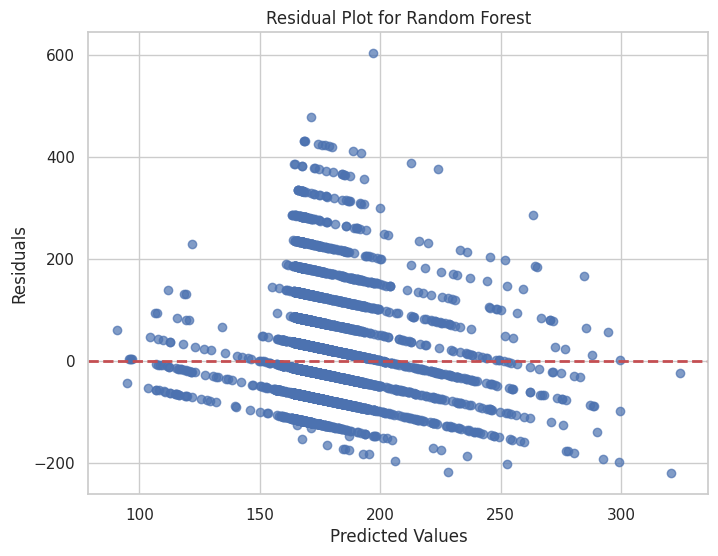

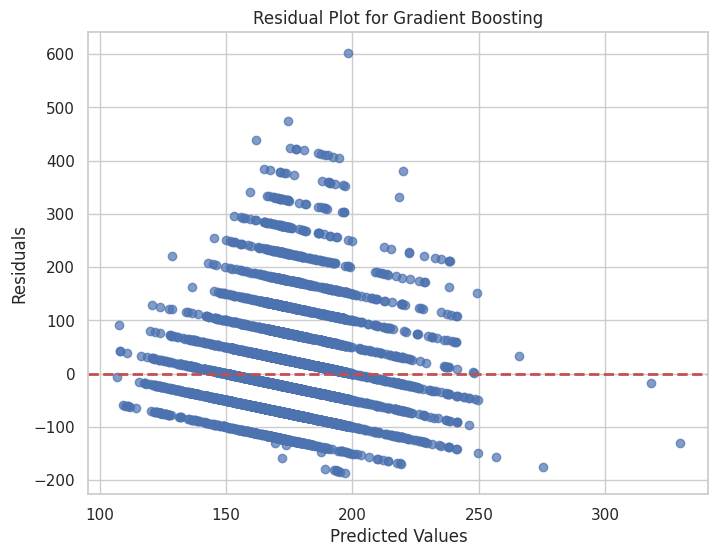

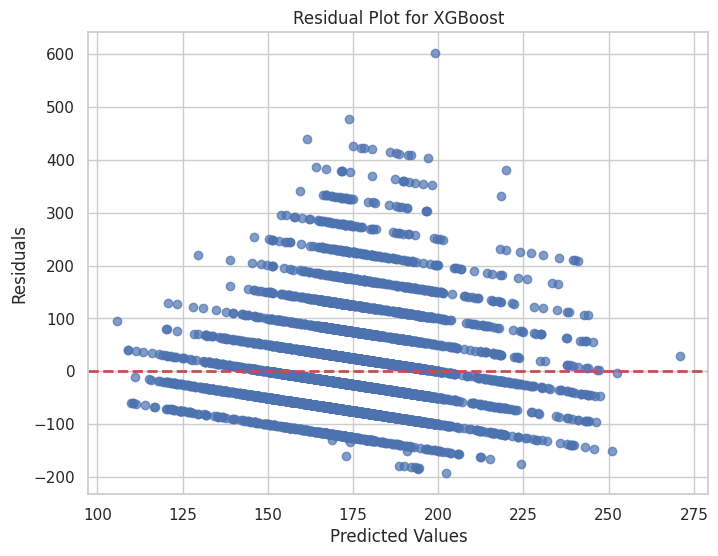

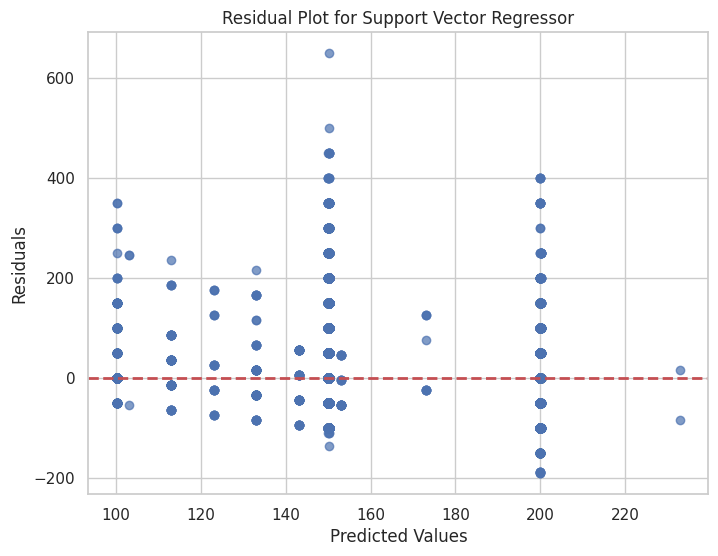

In [13]:
import matplotlib.pyplot as plt

for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    residuals = y_test - y_pred

    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, residuals, alpha=0.7)
    plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
    plt.title(f'Residual Plot for {model_name}')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.show()


####3.Distribution of Residuals
Visualize the distribution of residuals to check for normality.

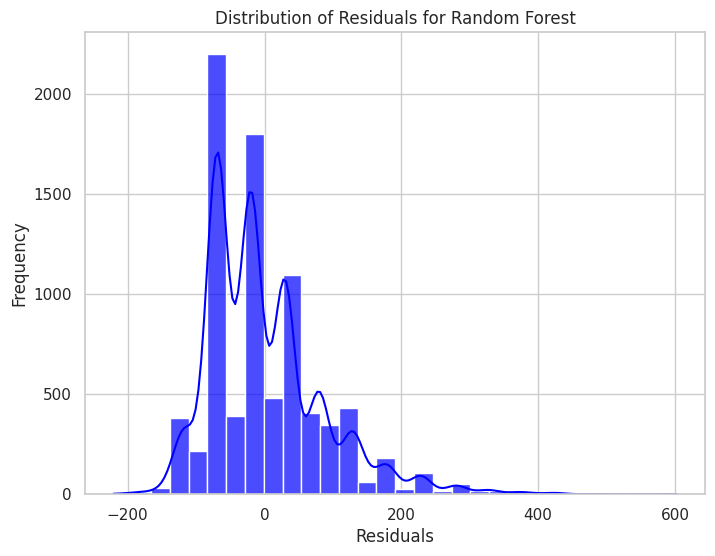

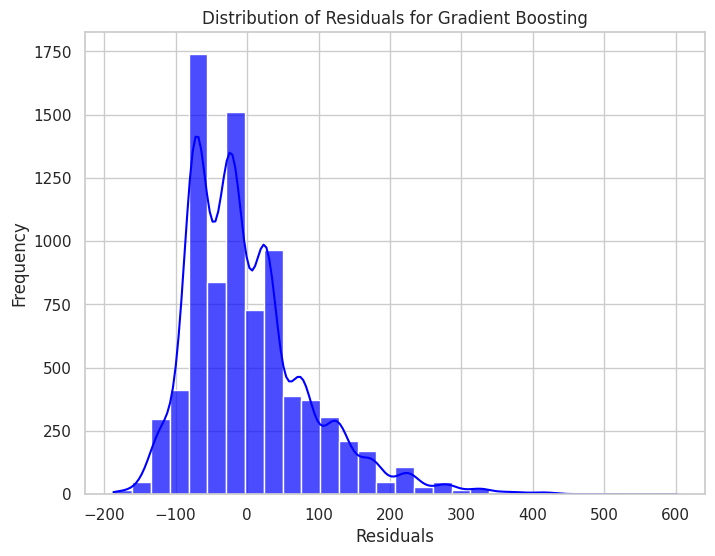

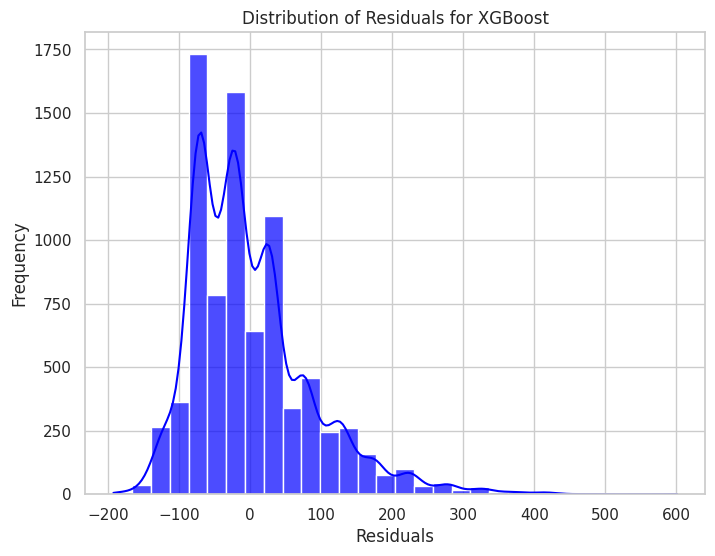

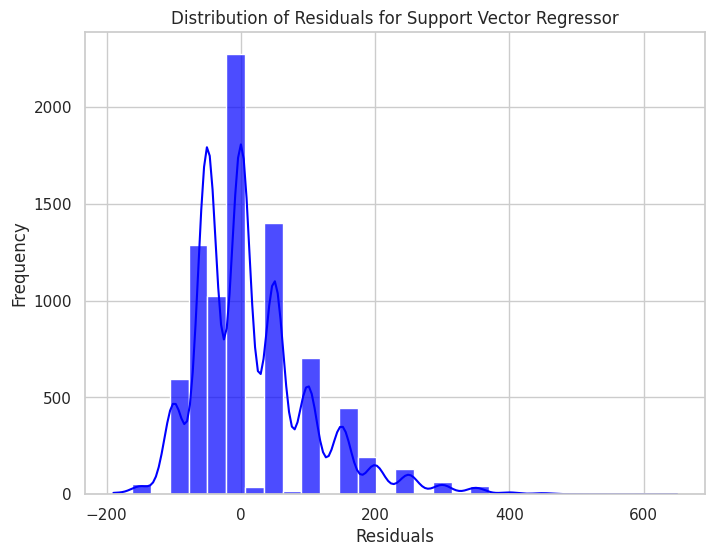

In [14]:
import seaborn as sns

for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    residuals = y_test - y_pred

    plt.figure(figsize=(8, 6))
    sns.histplot(residuals, kde=True, bins=30, color='blue', alpha=0.7)
    plt.title(f'Distribution of Residuals for {model_name}')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()


####4.Learning Curve
A learning curve shows how performance evolves as the training size increases.

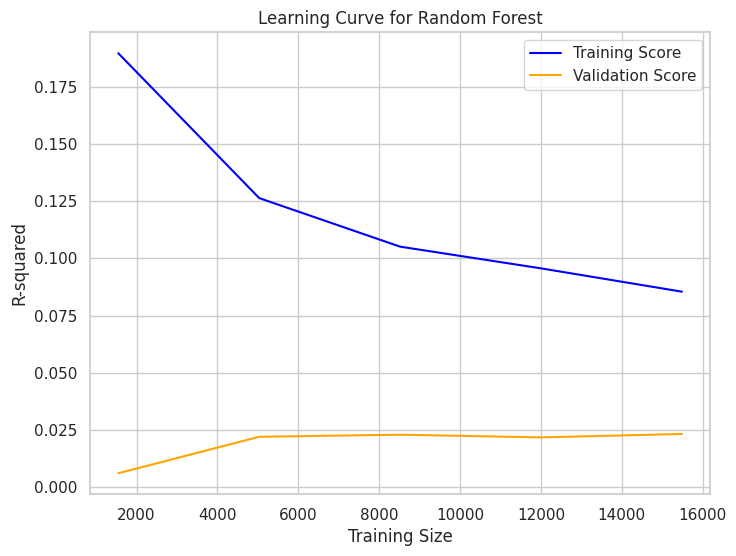

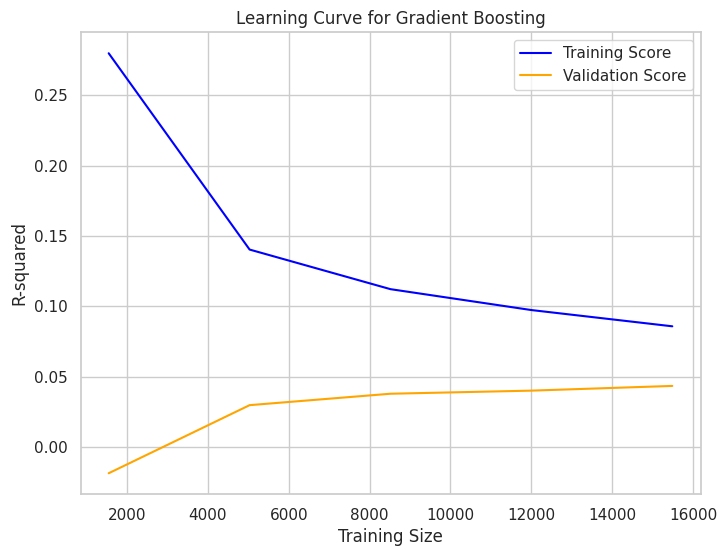

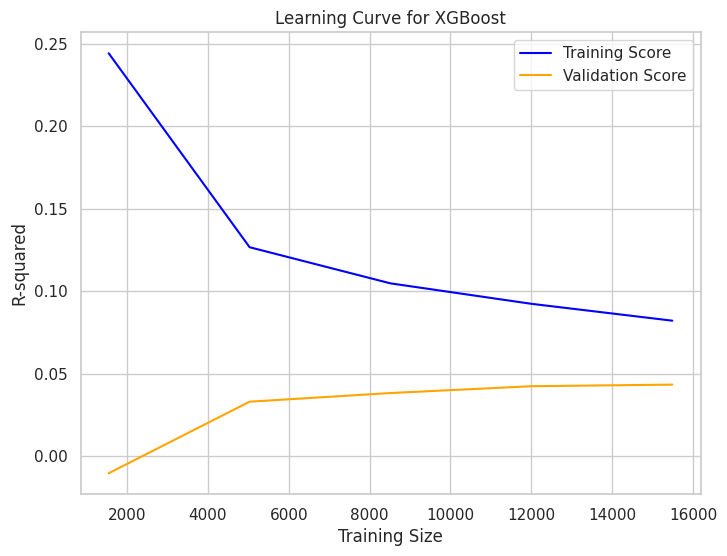

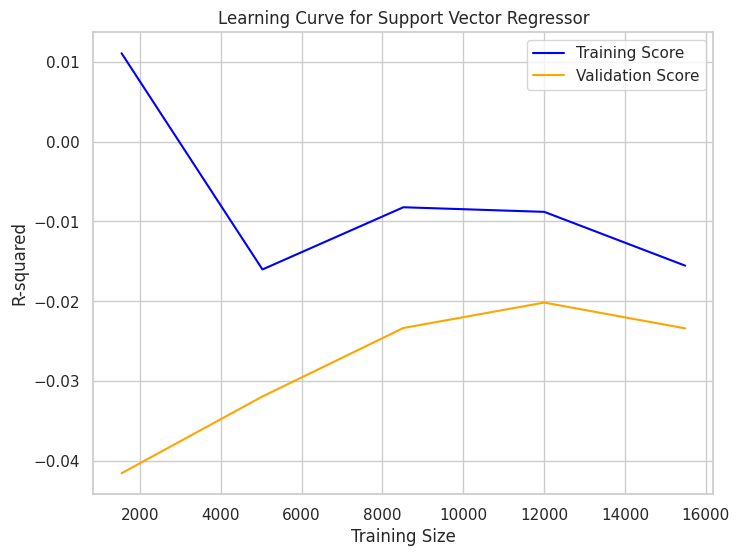

In [16]:
from sklearn.model_selection import learning_curve
import numpy as np

for model_name, model in best_models.items():
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train, y_train, cv=5, scoring='r2', n_jobs=-1
    )

    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, label='Training Score', color='blue')
    plt.plot(train_sizes, test_mean, label='Validation Score', color='orange')
    plt.title(f'Learning Curve for {model_name}')
    plt.xlabel('Training Size')
    plt.ylabel('R-squared')
    plt.legend()
    plt.show()


####5.Predicted vs. Actual Values Plot
A scatter plot to compare predictions against the actual values.

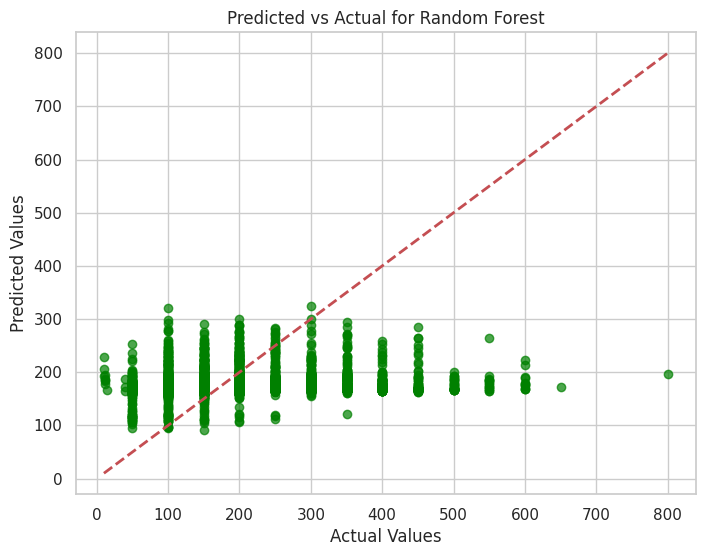

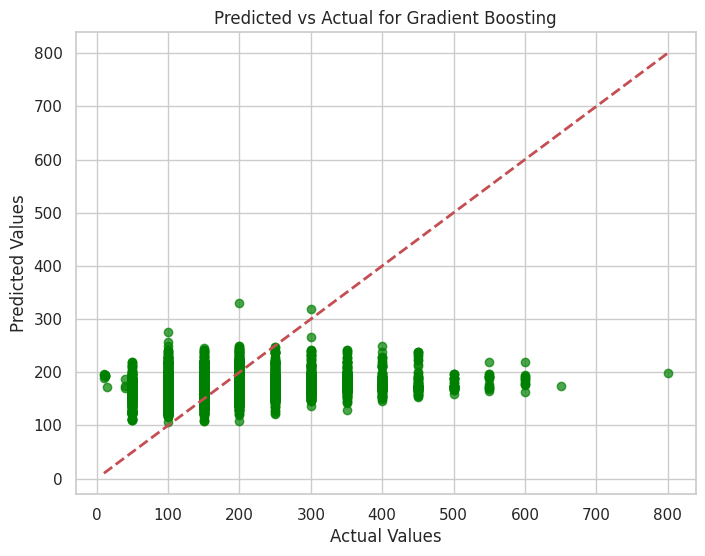

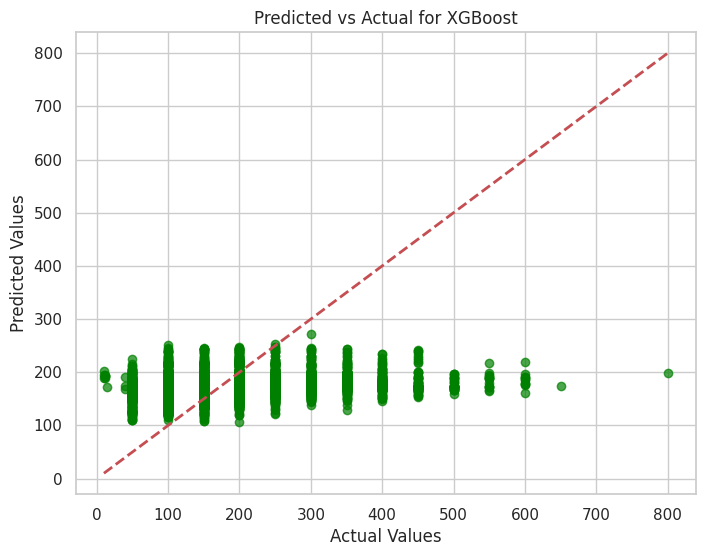

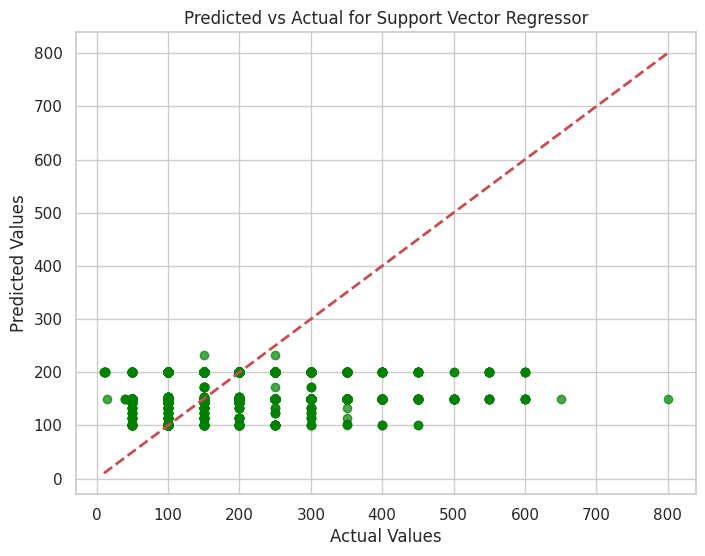

In [17]:
for model_name, model in best_models.items():
    y_pred = model.predict(X_test)

    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.7, color='green')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
    plt.title(f'Predicted vs Actual for {model_name}')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.show()


####6.Error Metrics
Print the evaluation metrics (MAE, MSE, RMSE, R²) for each model.

In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

print("Evaluation Metrics for Each Model:")
for model_name, model in best_models.items():
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"{model_name}:")
    print(f"  Mean Absolute Error (MAE): {mae:.2f}")
    print(f"  Mean Squared Error (MSE): {mse:.2f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"  R-squared (R²): {r2:.2f}")
    print("-" * 40)


Evaluation Metrics for Each Model:
Random Forest:
  Mean Absolute Error (MAE): 65.62
  Mean Squared Error (MSE): 7335.76
  Root Mean Squared Error (RMSE): 85.65
  R-squared (R²): 0.03
----------------------------------------
Gradient Boosting:
  Mean Absolute Error (MAE): 64.53
  Mean Squared Error (MSE): 7199.27
  Root Mean Squared Error (RMSE): 84.85
  R-squared (R²): 0.04
----------------------------------------
XGBoost:
  Mean Absolute Error (MAE): 64.58
  Mean Squared Error (MSE): 7199.75
  Root Mean Squared Error (RMSE): 84.85
  R-squared (R²): 0.04
----------------------------------------
Support Vector Regressor:
  Mean Absolute Error (MAE): 61.08
  Mean Squared Error (MSE): 7745.82
  Root Mean Squared Error (RMSE): 88.01
  R-squared (R²): -0.03
----------------------------------------
